In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [138]:
data = pd.read_csv('../../data/panel_data.csv')
data['year'] = [element.split('-')[0] for element in data['time']]
data['month'] = [element.split('-')[1] for element in data['time']]
data.head()

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,year,month
0,2020-01-01,TIBESTI,13.226863,0.006183,0.010336,0.264653,15.0,0.0,2020,01
1,2020-01-01,BORKOU,17.938311,0.001743,0.013868,0.356516,80.0,0.0,2020,01
2,2020-01-01,ENNEDI OUEST,14.834963,0.001229,0.053228,0.344716,58.0,0.0,2020,01
3,2020-01-01,WADI FIRA,18.471732,0.001052,0.268617,0.859191,600.0,0.0,2020,01
4,2020-01-01,SALAMAT,25.261679,0.001052,0.567471,1.311763,621.0,3.0,2020,01


# ACF and PACF

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df is your dataframe with 'time', 'entity', and 'cases' columns
entities = data['state'].unique()  # Get unique entities in the panel
n_entities = len(entities)  # Number of entities
ncols = 4  # Number of columns in the plot grid
nrows = (n_entities * 2 // ncols) + (n_entities * 2 % ncols > 0)   # Number of rows

# Create subplots
def plt_acfs(varname, entities, nrows, ncols, data):
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 2))  # Adjust figure size as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to iterate easily

    for i, entity in enumerate(entities):
        entity_data = data[data['state'] == entity].sort_values(by='time')[varname]  # Filter and sort data by time
        
        # Plot ACF
        plot_acf(entity_data, lags=20, ax=axs[i * 2])  # ACF plot
        axs[i * 2].set_title(f'ACF for {entity}')
        
        # Plot PACF
        plot_pacf(entity_data, lags=20, ax=axs[i * 2 + 1])  # PACF plot
        axs[i * 2 + 1].set_title(f'PACF for {entity}')

    # Remove any unused subplots (if nrows * ncols > number of plots)
    for j in range(i * 2 + 2, nrows * ncols):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.savefig(f'../../docs/acf-pacf-{varname}.png', format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

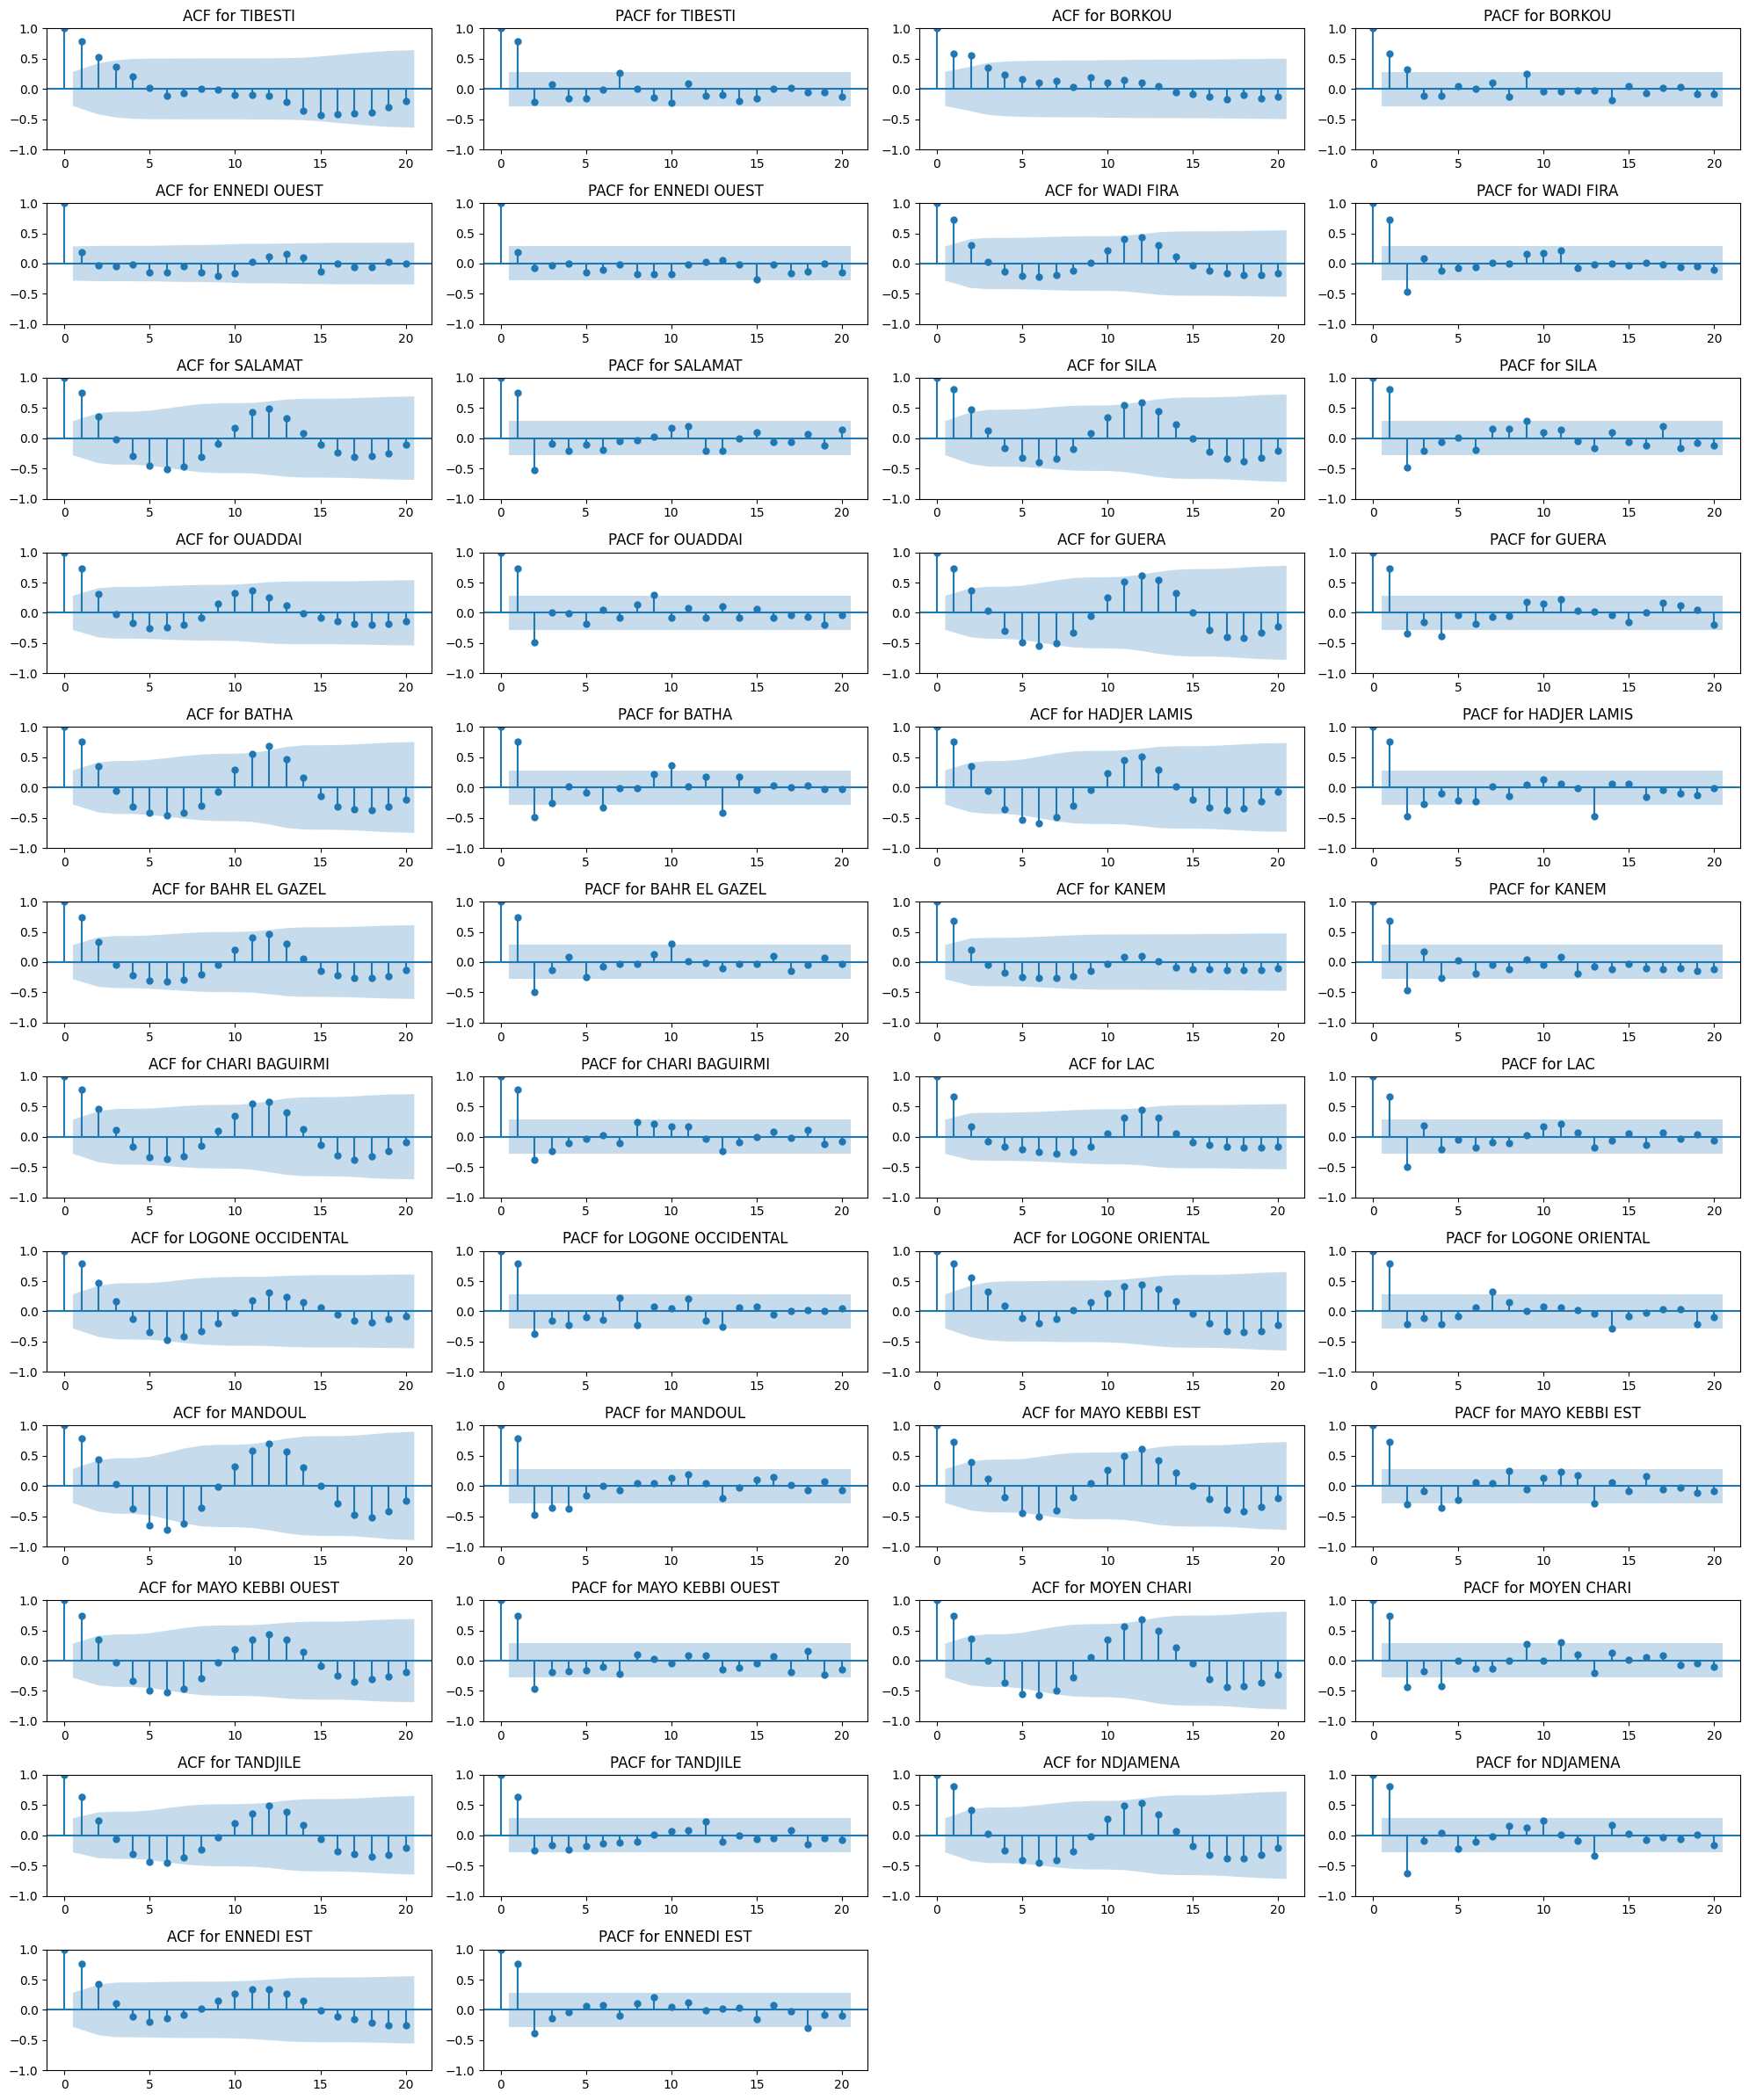

In [30]:
plt_acfs('cases', entities, nrows, ncols, data)

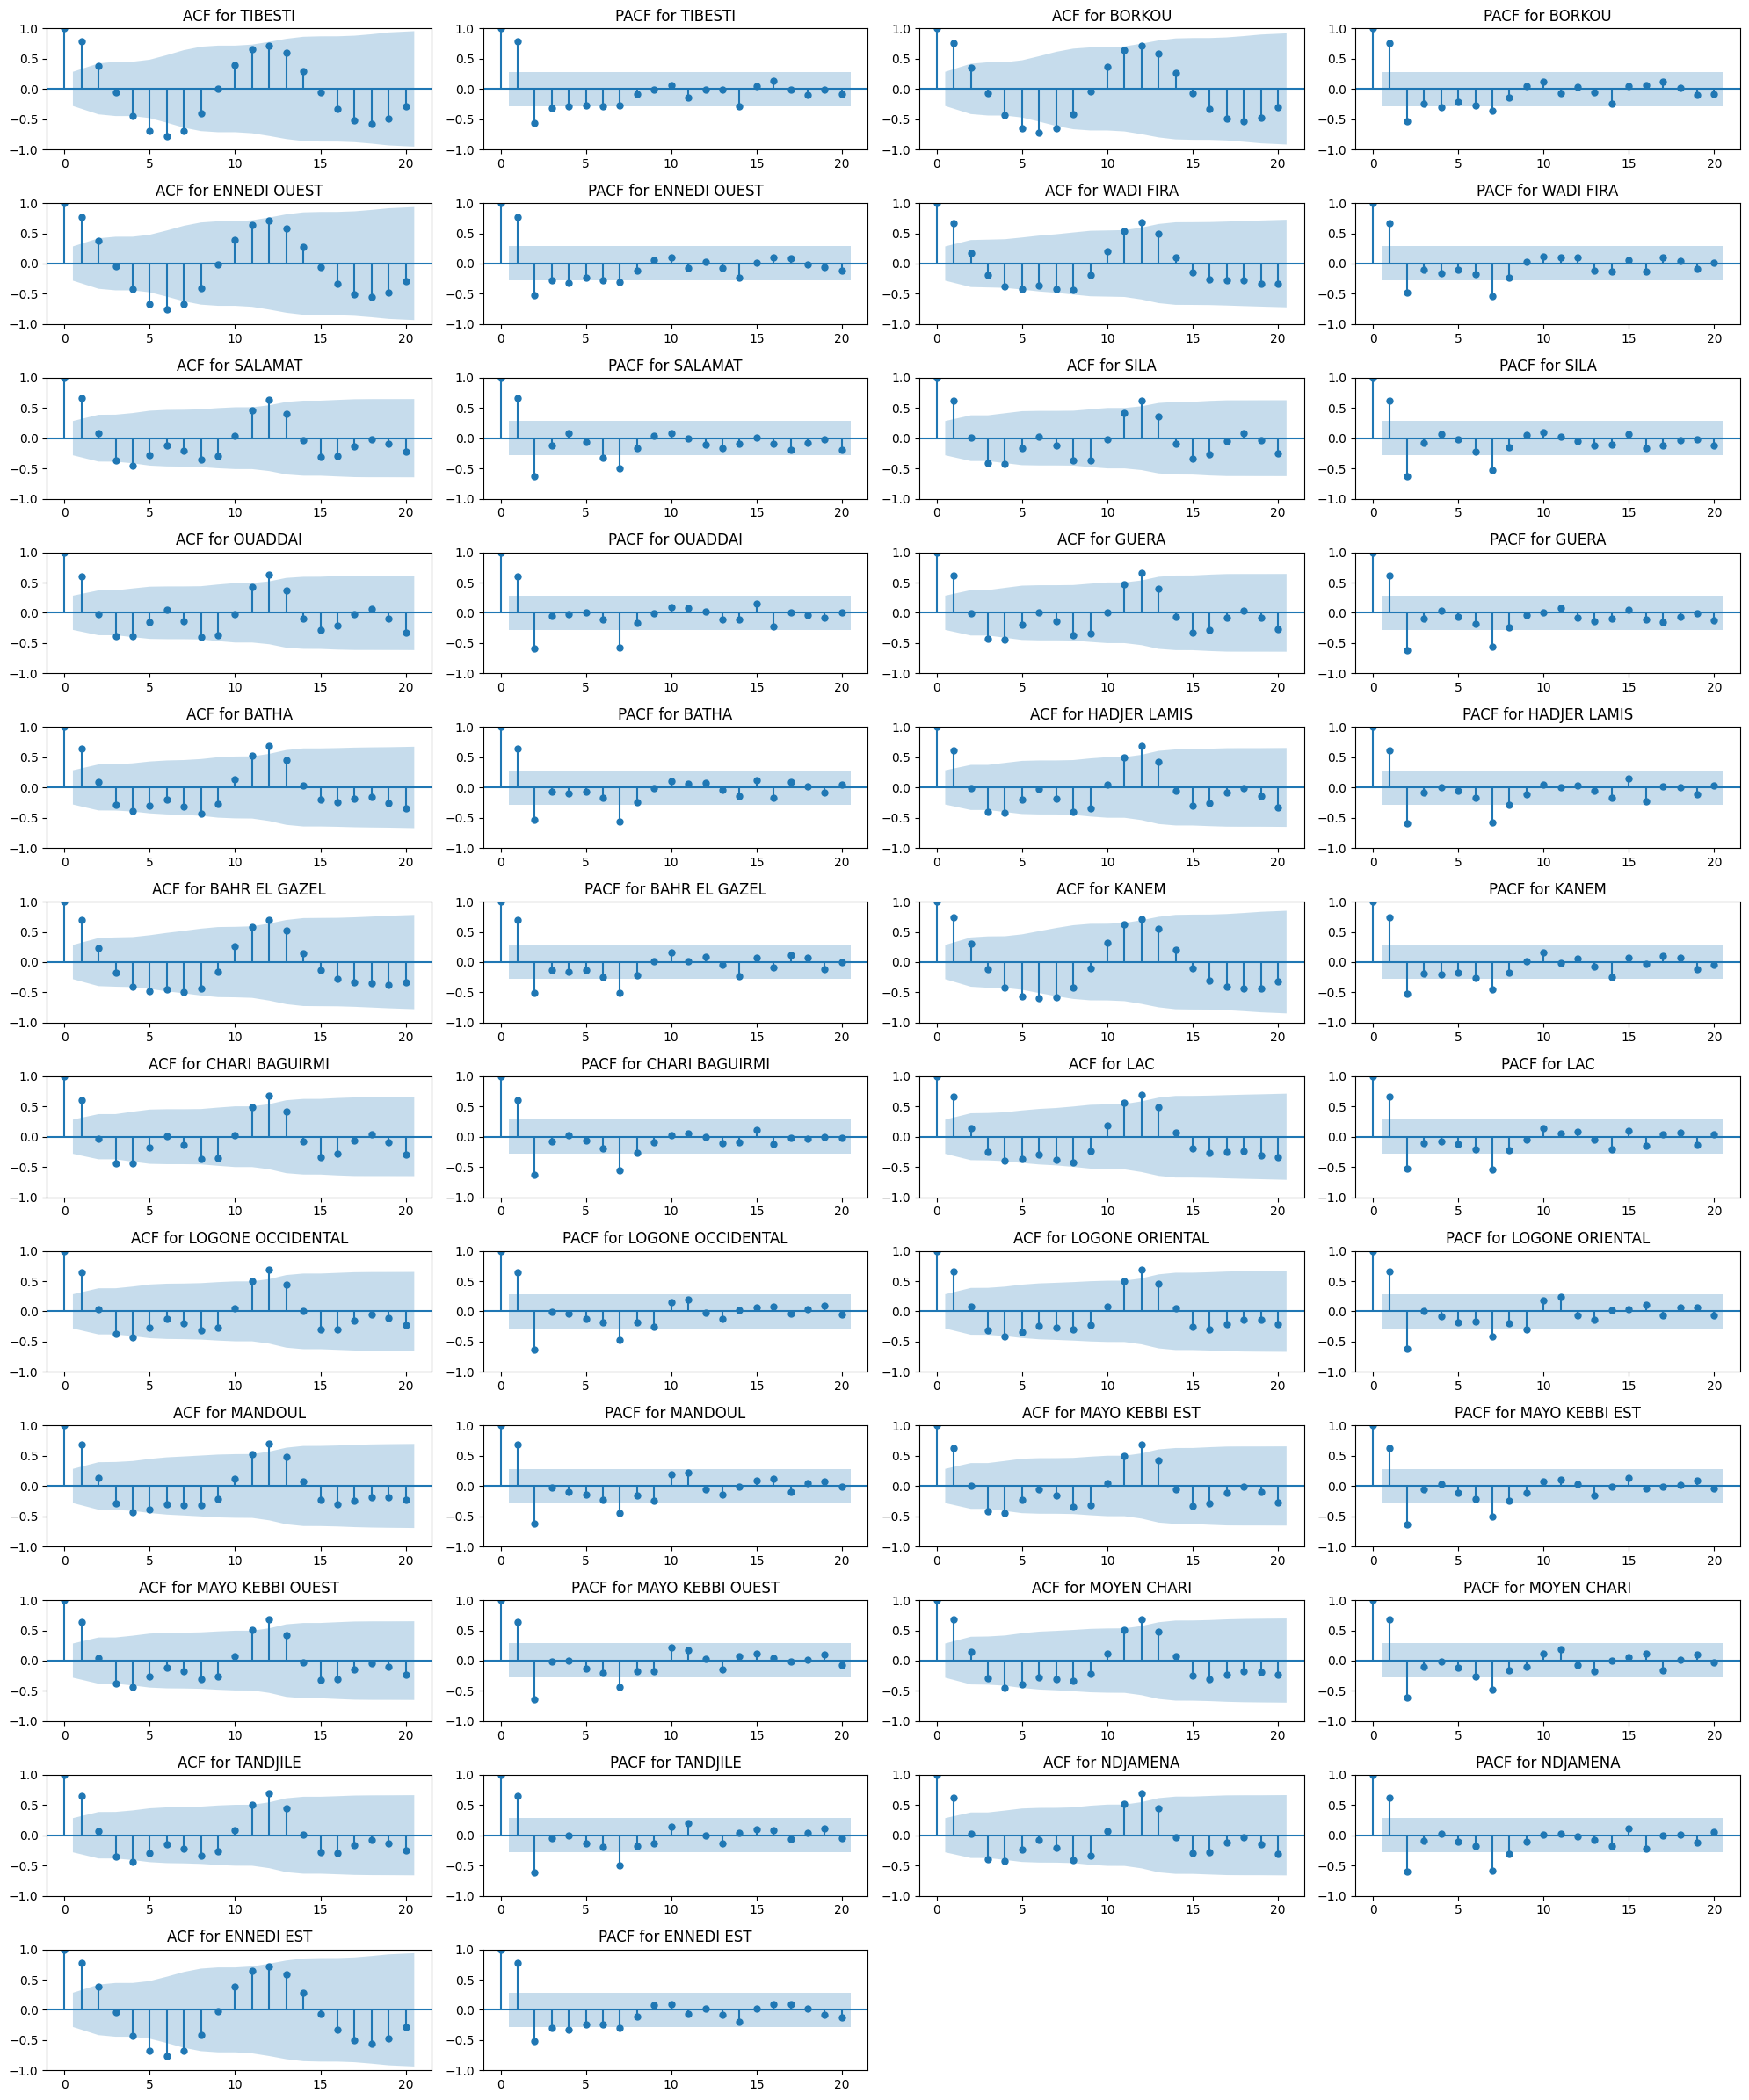

In [31]:
plt_acfs('t2m', entities, nrows, ncols, data)

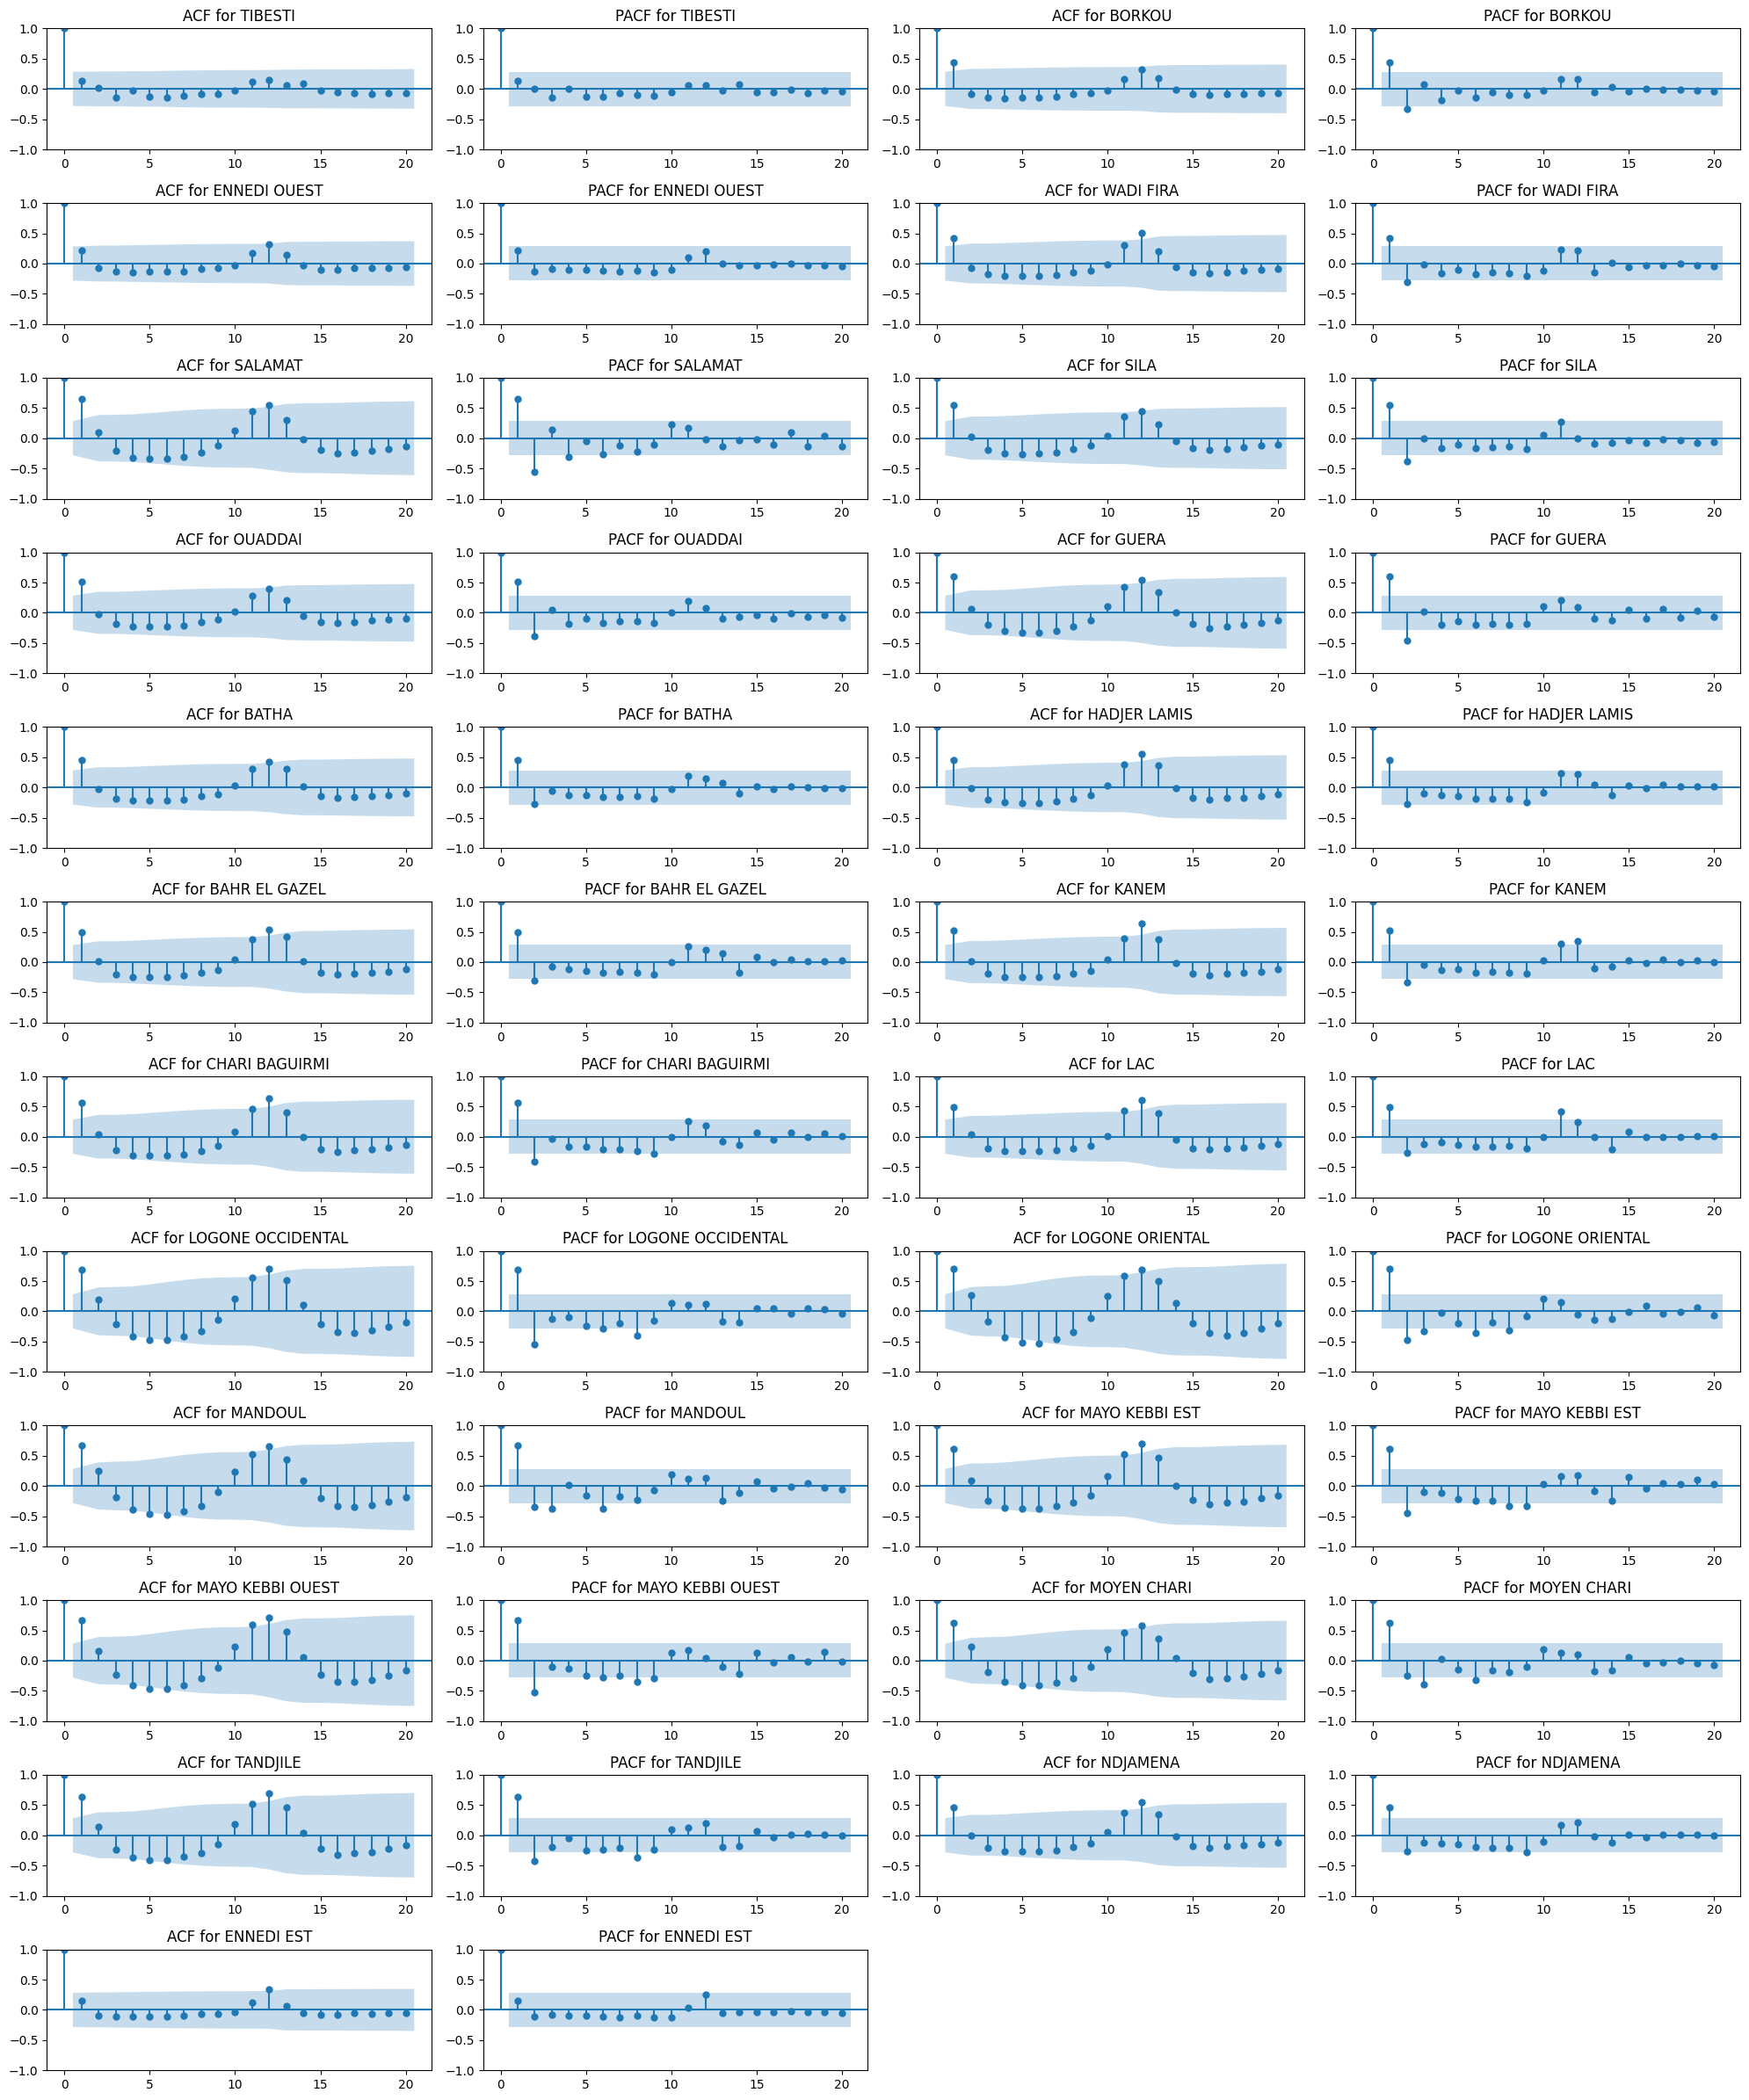

In [32]:
plt_acfs('tp', entities, nrows, ncols, data)

In [108]:
import pandas as pd
from  pydynpd import regression

command_str='cases L(1:2).cases t2m tp | gmm(t2m, 2:99) gmm(tp, 2:99)| nolevel collapse'
mydpd = regression.abond(command_str, data, ['state', 'time'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: state                            Number of obs = 1035     
 Time variable: time                              Min obs per group: 45    
 Number of instruments = 95                       Max obs per group: 45    
 Number of groups = 23                            Avg obs per group: 45.00 
+----------+--------------+---------------------+------------+-----------+-----+
|  cases   |    coef.     | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------+--------------+---------------------+------------+-----------+-----+
| L1.cases |  0.1554223   |      0.0367909      | 4.2244721  | 0.0000240 | *** |
| L2.cases |  -0.0175567  |      0.0699419      | -0.2510188 | 0.8017995 |     |
|   t2m    | 855.5048868  |     350.6337752     | 2.4398816  | 0.0146921 |  *  |
|    tp    | 3058.8316950 |     1056.9598447    | 2.8939904  | 0.0038038 |  ** |
+----------+--------------+---------------------+------------+-----------

# OLS estimation

In [131]:
df

,,t2m,tp,lai_hv,lai_lv,cases,deaths,year,month,cases_lag
state,time,,,,,,,,,
TIBESTI,2020-02-01,15.496618,0.001534,0.010336,0.264667,28.0,0.0,2020,02,15.0
BORKOU,2020-02-01,20.322452,0.001201,0.013868,0.356530,111.0,0.0,2020,02,80.0
ENNEDI OUEST,2020-02-01,17.426777,0.001499,0.053228,0.344859,56.0,0.0,2020,02,58.0
WADI FIRA,2020-02-01,21.029076,0.000976,0.268518,0.866607,462.0,0.0,2020,02,600.0
SALAMAT,2020-02-01,28.540551,0.000975,0.568094,1.302452,567.0,4.0,2020,02,621.0
...,...,...,...,...,...,...,...,...,...,...
MAYO KEBBI OUEST,2023-12-01,26.830964,0.000435,1.075013,1.483485,5125.0,0.0,2023,12,7140.0
MOYEN CHARI,2023-12-01,27.814579,0.000619,1.378152,1.518212,10356.0,0.0,2023,12,11662.0
TANDJILE,2023-12-01,26.699490,0.000435,1.476067,1.587397,7537.0,0.0,2023,12,10761.0


In [134]:
import pandas as pd
from linearmodels.panel import PanelOLS

data['time'] = pd.to_datetime(data['time']) 
df = data.set_index(['state', 'time'])

# Create lagged dependent variable
df['cases_lag'] = df.groupby('state')['cases'].shift(1)

# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = df['cases']
X = df[['cases_lag', 't2m', 'tp', 'year', 'month', 'region']]

# Fit dynamic panel model (Fixed effects)
model_ols = PanelOLS(y, X, entity_effects=True, time_effects=False)
results_ols = model_ols.fit()

# Display results
print(results_ols.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  cases   R-squared:                        0.7597
Estimator:                   PanelOLS   R-squared (Between):              0.5712
No. Observations:                1081   R-squared (Within):               0.7597
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.6142
Time:                        22:51:15   Log-likelihood                   -9598.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      193.60
Entities:                          23   P-value                           0.0000
Avg Obs:                       47.000   Distribution:                 F(17,1041)
Min Obs:                       47.000                                           
Max Obs:                       47.000   F-statistic (robust):             193.60
                            

/tmp/ipykernel_6028/626832726.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

region.BATHA, region.BORKOU, region.CHARI BAGUIRMI, region.ENNEDI EST, region.ENNEDI OUEST, region.GUERA, region.HADJER LAMIS, region.KANEM, region.LAC, region.LOGONE OCCIDENTAL, region.LOGONE ORIENTAL, region.MANDOUL, region.MAYO KEBBI EST, region.MAYO KEBBI OUEST, region.MOYEN CHARI, region.NDJAMENA, region.OUADDAI, region.SALAMAT, region.SILA, region.TANDJILE, region.TIBESTI, region.WADI FIRA

  results_ols = model_ols.fit()


In [113]:
# Extract Fixed (Entity) Effects
fixed_effects = results_ols.estimated_effects
print("\nFixed Effects (Entity Effects):\n", fixed_effects)


Fixed Effects (Entity Effects):
                              estimated_effects
state            time                         
TIBESTI          2020-02-01        2207.492612
BORKOU           2020-02-01        2940.815208
ENNEDI OUEST     2020-02-01        2555.273443
WADI FIRA        2020-02-01        3091.342205
SALAMAT          2020-02-01        3348.166202
...                                        ...
MAYO KEBBI OUEST 2023-12-01        3889.383275
MOYEN CHARI      2023-12-01        5526.860628
TANDJILE         2023-12-01        4756.183068
NDJAMENA         2023-12-01        6353.807491
ENNEDI EST       2023-12-01        2272.147978

[1081 rows x 1 columns]


# Random Effects

In [139]:
import pandas as pd
from linearmodels.panel import RandomEffects

data['time'] = pd.to_datetime(data['time']) 
data['region'] = data['state']
df = data.set_index(['state', 'time'])


# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = df['cases']
X = df[['t2m', 'tp', 'year', 'month', 'region']]

model_random = RandomEffects(y, X)
results_random = model_random.fit()

# Display results
print(results_random.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  cases   R-squared:                        0.8818
Estimator:              RandomEffects   R-squared (Between):              0.9997
No. Observations:                1104   R-squared (Within):               0.4840
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.8818
Time:                        23:30:53   Log-likelihood                -1.022e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      209.37
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(38,1066)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):             209.37
                            

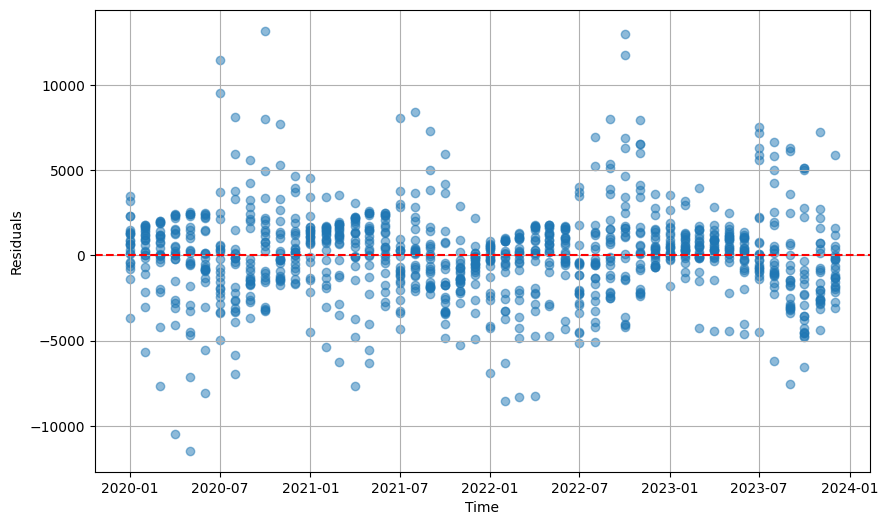

In [141]:
# Extract residuals
residuals = results_random.resids

# Create a residuals plot
plt.figure(figsize=(10,6))

# Option 1: Using Matplotlib
plt.scatter(residuals.index.get_level_values(1), residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

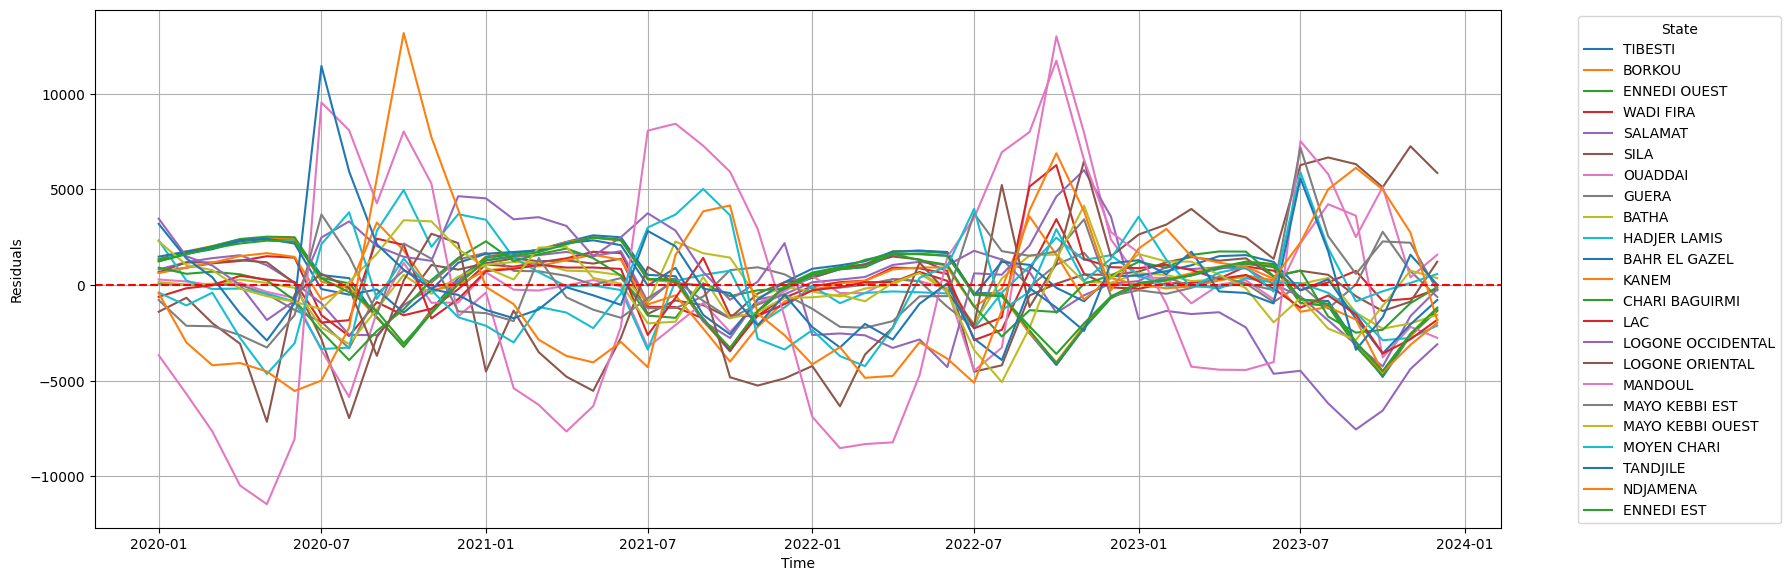

In [140]:
# Extract residuals
residuals = results_random.resids

# Extract index levels: 'state' and 'time' (or whatever your index names are)
states = residuals.index.get_level_values(0)  # State level (first level)
time = residuals.index.get_level_values(1)  # Time level (second level)

# Convert residuals to DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'state': states,
    'time': time
})

# Plot residuals for each state using a line plot
plt.figure(figsize=(18, 6))
for state in residuals_df['state'].unique():
    state_residuals = residuals_df[residuals_df['state'] == state]
    plt.plot(state_residuals['time'], state_residuals['residuals'], label=state)

# Customize the plot
plt.axhline(0, color='r', linestyle='--')
# plt.title('Residuals Over Time by State')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.savefig('../../docs/residuals.png', format='png', bbox_inches='tight', pad_inches=0)
plt.show()

# Test for individual random effects (Hausman)

In [100]:
from scipy import stats

# 3. Extract coefficients and covariance matrices
beta_fixed = results_ols.params
beta_random = results_random.params

cov_fixed = results_ols.cov
cov_random = results_random.cov

# 4. Compute the Hausman test statistic
diff = beta_fixed - beta_random
chi2_stat = np.dot(np.dot(diff.T, np.linalg.inv(cov_fixed - cov_random)), diff)
p_value = stats.chi2.sf(chi2_stat, df=len(diff))

# Display the results
print(f"Hausman test statistic: {chi2_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject null hypothesis: Fixed Effects model is preferred.")
else:
    print("Fail to reject null hypothesis: Random Effects model is preferred.")


Hausman test statistic: 62.51834025536211
P-value: 1.7023383371844174e-13
Reject null hypothesis: Fixed Effects model is preferred.


In [101]:
results_random.estimated_effects

,,estimated_effects
state,time,
TIBESTI,2020-02-01,0.0
BORKOU,2020-02-01,0.0
ENNEDI OUEST,2020-02-01,0.0
WADI FIRA,2020-02-01,0.0
SALAMAT,2020-02-01,0.0
...,...,...
MAYO KEBBI OUEST,2023-12-01,0.0
MOYEN CHARI,2023-12-01,0.0
TANDJILE,2023-12-01,0.0


In [63]:
results_random.df_resid

1078

In [90]:
from linearmodels.panel import compare
from linearmodels.panel import PanelOLS

# Compare the random effects and fixed effects models
comparison = compare({"Random Effects": results_random, "Fixed Effects": results_ols})
print(comparison)

                    Model Comparison                    
                           Random Effects  Fixed Effects
--------------------------------------------------------
Dep. Variable                       cases          cases
Estimator                   RandomEffects       PanelOLS
No. Observations                     1081           1081
Cov. Est.                      Unadjusted     Unadjusted
R-squared                          0.9233         0.6973
R-Squared (Within)                 0.6817         0.6973
R-Squared (Between)                0.9948         0.9779
R-Squared (Overall)                0.9233         0.9139
F-statistic                        4326.8         810.12
P-value (F-stat)                   0.0000         0.0000
=====================     ===============   ============
cases_lag                          0.8479         0.7257
                                 (74.053)       (41.504)
t2m                                6.2978         18.123
                               